# Data Analyst Nano Degree P2 Project
## Examination of Sean Lahman's Baseball Database
### Data Analysis Proecess - Part 1 - Question Phase
Based on the recent Baseball Hall of Fame (HoF) elections and the inclusion Tim Raines (a player who was ingnored by the Hall of Fame for many years, until a number of Sabermetrics writers and analyists generated support for him), I wanted to examine baseball statistics in relation ship to the Major League Baseball (MLB) Hall of fame. For this I will use multiple tables in [Sean Lahman's Baseball Database](http://www.seanlahman.com/baseball-archive/statistics/). Specifically, I am interested in differences around offensive statistics for those in the HoF compared to those not in the HoF. For example how do batting averages, RBIs, hits and home runs compare for those in the HoF vs. those not in the HoF. In addition to simply looking at the data, I also wanted to do a hypothesis test of a specific statistic comparing these two groups. While there are a lot of traditional and advanced stats to explore for this comparison, I wanted to keep the comparison relatively simple and focus on career batting average. Also, since the data set is extremely large (every player to ever be on an MLB roster from 1871 through 2016), I will keep my analysis limited to players who debuted after January 1, 1960 (focusing on the modern era of baseball). The hypothesis I would like to test is whether the mean career batting average of baseball players in hall of fame in statistically different from the mean career batting average of baseball players NOT in the hall of fame.

*independent two-sample t-test*<br/>
*H_0: x = y*<br/>
*H_A: x != y*<br/>
*Where x = mean career batting average of players who debuted in MLB after January 1, 1960 who **ARE** in the Hall of fame*<br/>
*Where y = mean career batting average of players who debuted in MLB after January 1, 1960 who **ARE NOT** in the Hall of fame*<br/>
*Confidence interval = 95%<br/>

This report will continue through the remaining steps in the **Data Analysis Process** outlined in the Udacity DAND course, including:
1. Data Wrangling
 1. Data aquisition and uploading
 1. Limiting data sample based on player debut
 1. Merging necessary tables
 1. Development of Batting Average Statistic
2. Data Exploration
 1. Exploring various offensive statistics, both using descriptive statistics and graphs
 1. Making predictions based on the data
 1. Conducting t-test to reject or fail to reject Null Hypothesis
3. Communication of Findings
 1. Review the findings from the data exploration and make conclusions
 1. Discuss possible future analysis opportunities

### Data Analysis Proecess - Part 2 - Data Wrangling
Sean Lahman's Baseball Database involves a **HUGE** amount of data, broken into 4 *main* tables and *23* suplemental tables. For my analysis of offensive statistics for Hall of Fame and non-Hall of Fame players, I will utilize three tables:
1. Master Table 
2. Batting Table
3. Hall Of Fame Table

For additional information on the tables and what is included, see the [Documentation](http://seanlahman.com/files/database/readme2016.txt) 

The master table includes all players who have ever played Major League Baseball, along with some personal statisitcs, including their MLB debut date. In addition, each player is giving a unique 'PlayerID'. The unique PlayerID will allow me to merge the three lists and create a master Pandas DataFrame that includes the PlayerID, key batting statistics and whether the individual was elected into the hall of fame.

The following code will:
1. Upload the three databased into Pandas Dataframes
2. Drop all players who debuted *before* January 1, 1960 from the master Dataframe
3. Clean up the three DataFrames to include only the most relevant columns

In [1]:
#Step 1: Upload Master Table as a PD data frame and drop players who before January 1, 1960.
import pandas as pd
from datetime import datetime, time, date

#Upload the three tables and Pandas DataFrames
master_df = pd.read_csv('master.csv')
batting_df = pd.read_csv('Batting.csv')
halloffame_df = pd.read_csv('HallOfFame.csv')

#Create a datetime variable to coincide with January 1, 1960 that matches the format in the Master Dataframe.
nineteen_60 = datetime.strptime('1960-01-01','%Y-%m-%d')

#Conver the debut column in the Master Dataframe to a datetime object so I can compare it to the January 1, 1960 variable
master_df['debut'] = pd.to_datetime(master_df['debut'])

#Create a new DataFrame that only contains the individuals who debuted after January 1, 1960
master_1960 = master_df[(master_df['debut'] >= nineteen_60)]


#dropping all other data from Master Dataframe, since only really need playerID and debut
master_1960_min1 = master_1960.drop(master_1960.columns[1:20], axis=1)
master_1960_min = master_1960_min1.drop(master_1960_min1.columns[2:5], axis=1)

#dropping all non-relevant data from Batting Dataframe
batting_df_min1 = batting_df.drop(batting_df.columns[1:6], axis=1)
batting_df_min = batting_df_min1.drop(batting_df_min1.columns[12:17], axis=1)


#Drop all non-relevant data from Hall of Fame Data Frame
halloffame_df_min1 = halloffame_df.drop(halloffame_df.columns[1:6], axis=1)
halloffame_df_min = halloffame_df_min1.drop(halloffame_df_min1.columns[3], axis=1)

'''
The Hall of Fame Table includes all eligible players who appeared on the Hall of Fame voting results. It 
also includes Managers and Executives. To restrict the data to only Hall of Fame Players, I am creating a new
dataframe with only Hall of Fame inducted players
'''
#Dataframe of only individuals elected to the Hall of Fame
HOFonly_df = halloffame_df_min[(halloffame_df_min['inducted'] == 'Y')]

#Datafram on only Players elected to the Hall of fame
HOFPlayersonly_df = HOFonly_df[(HOFonly_df['category'] == 'Player')]

Now that I have the three key dataframes cleaned up, I now want to merge the dataframes into a *new* "master" dataframe that includes columns from the three original, cleaned dataframes. To faciliate the analysis of the Hall of Fame (HoF) vs. non-HoF players, I will also make two additional dataframes. One will only include HoF players and one will include only players *not* elected to the Hall of fame.

1. First, I will merge master dataframe with the batting dataframe based on the unique PlayerID variable and I will use an inner merge, so only the batting records and HoF records for players in the post-1960 dataframe will be included. 
2. Next I will merge the full, post-1960, batting dataframe with the Hall of Fame dataframe. But because I want to include both the HoF players and the non-HoF players, for the next dataframes, I use a left merge, where the left dataframe is master batting data frame. 
3. From this new dataframe, I will create two distinct dataframes. One that only includes players elected to the Hall of Fame and one that includes all players not elected to the hall of fame.

In [2]:
import pandas as pd
from datetime import datetime, time, date
import numpy as np

#Merging the master database for post 1960 players with batting dataframe
players_batter_df = pd.merge(master_1960_min, batting_df_min, how='inner', on='playerID')

#Merge the master with batting statistics for all players and whether they were inducted into HOF
full_players_df = pd.merge(players_batter_df, HOFPlayersonly_df, how='left', on='playerID').copy()

#Creating a new datafram with batting statistics for ONLY HOF players
full_HoF_only_df = full_players_df[(full_players_df['inducted'] == 'Y')].copy()

##datafram with batting statistics for ONLY NON-HOF players
full_non_HOF_df = full_players_df[(full_players_df['inducted'] != 'Y')].copy()

While the batting dataframe is comprehensive, it does not include the key statistic for my hypothesis test, batting average. Batting average is a simple statistic that takes the total number of hits in a season and divides it by the total number of at bats. To get batting average, I created a function to calcuate batting average based on the at bats and hits column in the dataframe and retuns the restuls in a new column "BA". Since the databases include each season a player was on a roster, including seasons when a player never bats or when they only bat a handful of times in a season, the function returns a flot(Nan) if a player recorded less than 100 at bats in a season. This will eliminate potential outliers (such as a player that goes 2 for 4 in a season, which would equal a .500 batting average), players on a roster who never bat in a season and non-offensive players (i.e. pitchers)

In [4]:
#Batting average function for players with at least 100 at bats
def batting_average(row):
    if row['AB'] < 100:
        return float('NaN')
    else:
        return float(row['H']) / row['AB']
    
#Apply the function to the three dataframes
full_players_df['BA'] = full_players_df.apply(batting_average, axis=1).astype(float)

full_HoF_only_df['BA'] = full_HoF_only_df.apply(batting_average, axis=1).astype(float)

full_non_HOF_df['BA'] = full_non_HOF_df.apply(batting_average, axis=1).astype(float)

Now each row in the three databases has a new Batting Average column. But the problem is that there is a row for each *season* a player was on an MLB roster, and for my analysis I want to look at the *career* statistics (mean for batting average and the sum of the other three batting statistics). To get career averages for the batting statistics and career totals for the other offensive statistics (hits, RBIs and HRs), I will create a new dataframe where data is grouped by the unique PlayerID and the mean or sum is generated for the appropriate columns. In addition to generating career averages, this process will also compress the dataframes to have only a single row for each player. This will allow me to see the sample sizes for the two comparison groups (which will be important for the hypothesis test later). 

In [5]:
#carrer batting average for ALL players
career_BA_all_players = full_players_df.groupby('playerID', as_index=False)['BA'].mean()

#carrer batting average for only HOF players
career_BA_HOF = full_HoF_only_df.groupby('playerID', as_index=False)['BA'].mean()

#carrer batting average for only non-HOF players
career_BA_non_HOF = full_non_HOF_df.groupby('playerID', as_index=False)['BA'].mean()

#carrer hits, RBIs and HRs for ALL players
career_H_HR_RBI_all_players = full_players_df.groupby('playerID', as_index=False)[['H', 'RBI', 'HR']].sum()

#carrer hits, RBIs and HRs for only HOF players
career_H_HR_RBI_HOF = full_HoF_only_df.groupby('playerID', as_index=False)[['H', 'RBI', 'HR']].sum()

#carrer hits, RBIs and HRs for only non-HOF players
career_H_HR_RBI_non_HOF = full_non_HOF_df.groupby('playerID', as_index=False)[['H', 'RBI', 'HR']].sum()

#Review the totals in the new databases, to make sure everything looks good.
print len(career_BA_HOF.index)
print len(career_BA_non_HOF.index)
print len(career_H_HR_RBI_all_players.index)
print len(career_H_HR_RBI_HOF.index)
print len(career_H_HR_RBI_non_HOF.index)

9604
55
9549
9604
55
9549


The final piece of preliminary *data wrangling* will involve removing the NaNs from the batting average dataframe. As mentioned before, I created the Batting Average ('BA') column to include NaN if a player did not record at least 100 at bats in a season. While the NaN won't effect built-in Panda functions (like .mean() and describe.()), it could cause issues with data visualization, so I just want to drop them now.

In [6]:
#Drop the NaNs from all players dataframe
clean_career_BA_all_players = career_BA_all_players.dropna()

#Drop the NaNs from HoF dataframe
clean_career_BA_HOF = career_BA_HOF.dropna()

#Drop the NaNs from non-HoF dataframe
clean_career_BA_non_HOF = career_BA_non_HOF.dropna()

#Review the new new sample sizes for Batting Average
print len(clean_career_BA_all_players.index)
print len(clean_career_BA_HOF.index)
print len(clean_career_BA_non_HOF.index)

3190
42
3148


### Data Analysis Proecess - Part 3 - Data Exploration
Now comes the **Fun** part. For my analysis I will compare Hall of Fame players with players not in the Hall of Fame to see if there are clear differences in offensive statistics and if the batting averages differences appear *statistically significant*. My data exploration will be conducted in three parts:
1. Compare the two groups using basic descriptive statistics, including mean and standard devition. 
2. Use data visualization to further examine the data
3. conduct a t-test on batting average to conduct the hypothesis test proposed during the question phase.

First, I would like to look at the two groups as they relate to career batting average.

In [7]:
print "HOF"
print clean_career_BA_HOF.describe()

print '\n' # Blank line to separate results

print "Non-HOF"
print clean_career_BA_non_HOF.describe()

HOF
              BA
count  42.000000
mean    0.270879
std     0.044638
min     0.130290
25%     0.269193
50%     0.279292
75%     0.294092
max     0.335374


Non-HOF
                BA
count  3148.000000
mean      0.248805
std       0.027408
min       0.058252
25%       0.232908
50%       0.250972
75%       0.266798
max       0.342020


Looking at the data we see that the average BA for HoF players is approximately .022 higher than non-HOF players. While not a huge number on the surface, when put in context of a career batting average, this difference is nothing to dismiss. Also interesting is the difference in standard deviation. The standard deviation for HOF players nearly *twice* as big as that for non-HOF players. Additionally, when we look at Coefficient of Variation/Relative Standard Deviation (std/mean) we get .165 (HOF) and .110, showing the distribution of career batting averages is noticeably larger/more spread out for the HOF players than non-HOF Player.

Next, I will examine the other hitting statistics for HOF and non-HOF players.

In [8]:
print "HOF"
print career_H_HR_RBI_HOF.describe()

print '\n' # Blank line to separate results

print "Non-HOF"
print career_H_HR_RBI_non_HOF.describe()

HOF
                 H          RBI          HR
count    55.000000    55.000000   55.000000
mean   1769.036364   885.636364  213.381818
std    1286.198921   679.534655  197.475970
min       9.000000     2.000000    0.000000
25%     198.500000    79.500000    5.500000
50%    2314.000000  1085.000000  207.000000
75%    2812.500000  1428.500000  380.500000
max    3419.000000  1917.000000  630.000000


Non-HOF
                 H          RBI           HR
count  9549.000000  9549.000000  9549.000000
mean    194.637135    90.986281    19.681537
std     433.757898   218.007784    55.895449
min       0.000000     0.000000     0.000000
25%       0.000000     0.000000     0.000000
50%       8.000000     3.000000     0.000000
75%     117.000000    51.000000     7.000000
max    4256.000000  2086.000000   762.000000


Now we can see some serious distinctions between HOF and non-HOF players! The mean career hits for HOF players is *over 9 times as big* as non-HOF players. And the other difference for the offensive statitics are also extremely large. While we can all assume there would be a difference between these two groups (getting elected to the HoF is only for the truely *great* players), something seems a bit odd with these numbers.  The low offensive statistics for the non-HOF players is probably the result of some low outliers, such as players who only played a season or part of a season and did poorly before being sent back to the minors. At the same time, there are some very good players who are not in the Hall of Fame (including all time hits leader Pete Rose, which is why the max hits for non-HoF is higher than HoF players), who help bring up the average. That said, since there is no weighting, a couple super good players not in the HoF can't balance out the hundreds of bad players who only had a season in MLB. Additionally, I suspect that a lot of the low values are also due to starting National League pitchers (for both HOF and non-HOF), who could reach 100 at bats over the course of a season. I will need to deal with this issue, but before I do anything, I'd like to see if some data visualization can help shine a little more light on the potential issue.

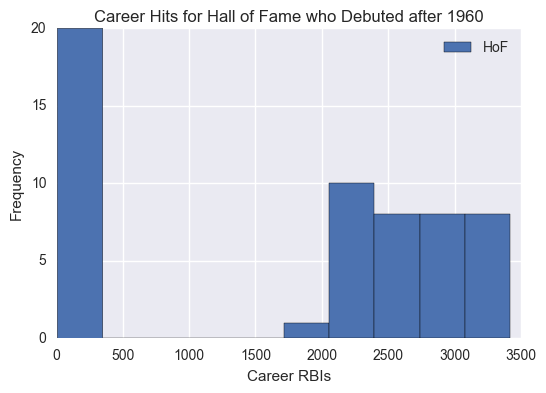

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

#Note: Because the difference in samples size is so large 55 vs. 9549, I cannot overlay the histograms.
%matplotlib inline
plt.hist(career_H_HR_RBI_HOF['H'], label='HoF')
plt.xlabel("Career RBIs")
plt.ylabel("Frequency")
plt.title("Career Hits for Hall of Fame who Debuted after 1960")
plt.legend(loc='upper right')

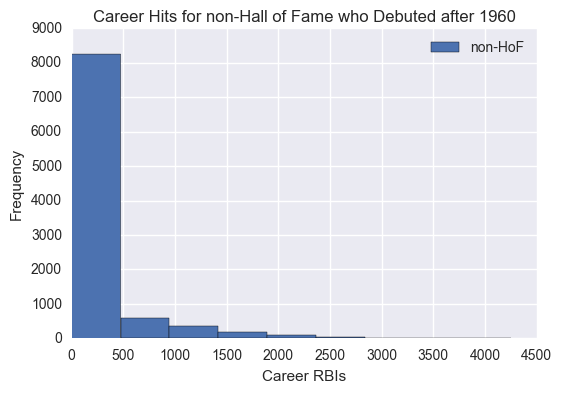

In [10]:
%matplotlib inline
plt.hist(career_H_HR_RBI_non_HOF['H'], bins=9, label='non-HoF')
plt.xlabel("Career RBIs")
plt.ylabel("Frequency")
plt.title("Career Hits for non-Hall of Fame who Debuted after 1960")
plt.legend(loc='upper right')

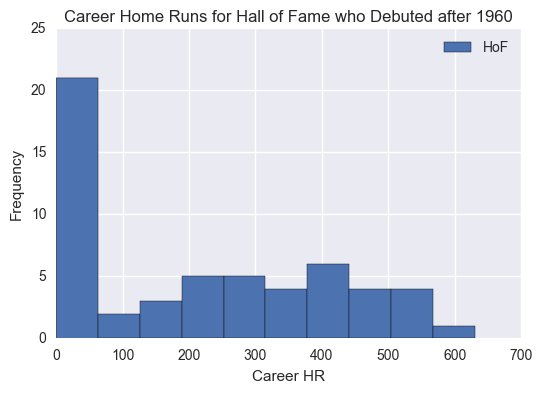

In [11]:
%matplotlib inline
plt.hist(career_H_HR_RBI_HOF['HR'], label='HoF')
plt.xlabel("Career HR")
plt.ylabel("Frequency")
plt.title("Career Home Runs for Hall of Fame who Debuted after 1960")
plt.legend(loc='upper right')

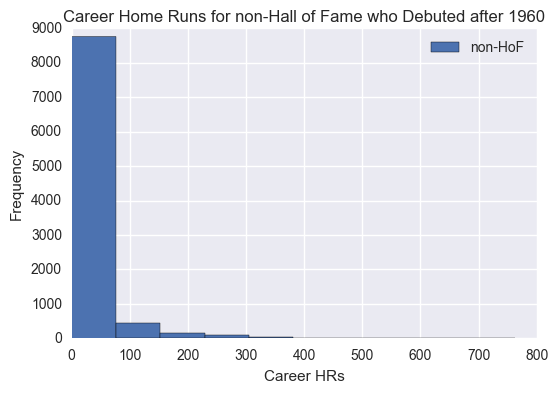

In [12]:
%matplotlib inline
plt.hist(career_H_HR_RBI_non_HOF['HR'], label='non-HoF')
plt.xlabel("Career HRs")
plt.ylabel("Frequency")
plt.title("Career Home Runs for non-Hall of Fame who Debuted after 1960")
plt.legend(loc='upper right')

Clearly, there is a problem with the data, as in both HOF and non-HOF group graphs there are a huge number of individuals in the lowest bin. Therefore, to get a more accurate look at these statistics, I will filter this data the same way I did for batting average and drop any season where the player did not have at least 100 at bats. I'm also going to limit the dataframe to only Hits, Home Runs and RBIs as that is the focus of my analysis.

In [13]:
#Take full HOF dataframe and droping all rows where the player did not have at least 100 at bats in that season
ab_100_full_HOF = full_HoF_only_df[full_HoF_only_df.AB >= 100][['playerID','AB', 'H', 'HR', 'RBI']].reset_index(drop=True).copy()

#Take full non-HOF dataframe and droping all rows where the player did not have at least 100 at bats in that season
ab_100_full_non_HOF = full_non_HOF_df[full_non_HOF_df.AB >= 100][['playerID','AB', 'H', 'HR', 'RBI']].reset_index(drop=True).copy()

In [14]:
#Grouping each dataframe by PlayerID and getting the sum
ab_100_career_H_HR_RBI_HOF = ab_100_full_HOF.groupby('playerID', as_index=False)[['H', 'RBI', 'HR']].sum()

ab_100_career_H_HR_RBI_non_HOF = ab_100_full_non_HOF.groupby('playerID', as_index=False)[['H', 'RBI', 'HR']].sum()

#Checking the length to make sure it matches the Career BA dataframe after the NaNs were dropped.
print len(ab_100_career_H_HR_RBI_HOF.index)
print len(ab_100_career_H_HR_RBI_non_HOF.index)

42
3148


Now let's re-examine the hits, RBIs and HR numbers where seaons with less than 100 at bats have been removed from a players career total.

In [15]:
print "HOF"
print ab_100_career_H_HR_RBI_HOF.describe()

print '\n' # Blank line to separate results

print "Non-HOF"
print ab_100_career_H_HR_RBI_non_HOF.describe()

HOF
                 H          RBI          HR
count    42.000000    42.000000   42.000000
mean   2253.976190  1134.690476  277.333333
std    1052.574741   570.930114  181.751058
min      37.000000    17.000000    0.000000
25%    2198.500000   976.500000  138.500000
50%    2479.500000  1260.000000  293.000000
75%    3021.250000  1559.750000  429.750000
max    3419.000000  1914.000000  630.000000


Non-HOF
                 H          RBI           HR
count  3148.000000  3148.000000  3148.000000
mean    549.652160   258.795426    57.109911
std     597.447247   310.757468    84.438883
min       6.000000     2.000000     0.000000
25%      92.000000    38.000000     6.000000
50%     309.000000   130.000000    22.000000
75%     819.500000   375.000000    74.000000
max    4221.000000  2084.000000   757.000000


**WOW** what a dramatic changes for *both* groups! The players/seasons with low at bats really dragged down the means. The Hall of Famers' means went from 1769, 885 and 213 (for hits, RBIs and HRs) to 2254, 1135 and 277! The *aveage* number of hits and RBIs increased by 485 and 250, respectively. 

For the non-Hall of Famers, the means went from 195, 91 and 20 (for hits, RBIs and HRs) to 550, 259 and 57. Both hits and RBI are more than 2.8 times as big after I removed seasons where players did not have at least 100 at bats. 

It is also important to address the dramatic drop in non-HOF players involved in this calculation, from 9549 to 3148. This is most likely due to the large number of pitchers on rosters (specifically in the national league) and the large number of individuals with extremely limited MLB careers. 

Now I would like to re-visit the visualizations with these new dataframes:

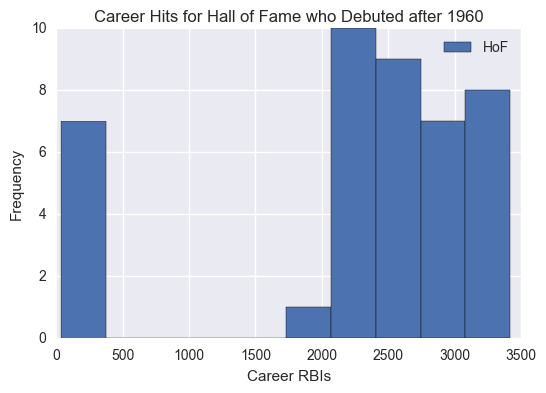

In [16]:
%matplotlib inline
plt.hist(ab_100_career_H_HR_RBI_HOF['H'], label='HoF')
plt.xlabel("Career RBIs")
plt.ylabel("Frequency")
plt.title("Career Hits for Hall of Fame who Debuted after 1960")
plt.legend(loc='upper right')

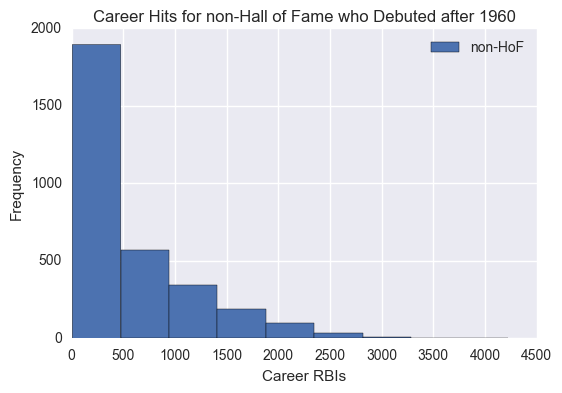

In [17]:
%matplotlib inline
plt.hist(ab_100_career_H_HR_RBI_non_HOF['H'], bins=9, label='non-HoF')
plt.xlabel("Career RBIs")
plt.ylabel("Frequency")
plt.title("Career Hits for non-Hall of Fame who Debuted after 1960")
plt.legend(loc='upper right')

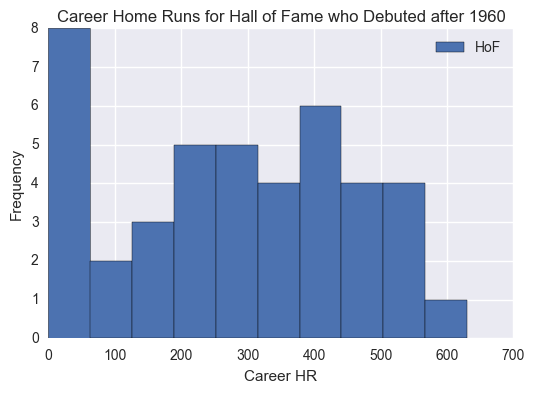

In [18]:
%matplotlib inline
plt.hist(ab_100_career_H_HR_RBI_HOF['HR'], label='HoF')
plt.xlabel("Career HR")
plt.ylabel("Frequency")
plt.title("Career Home Runs for Hall of Fame who Debuted after 1960")
plt.legend(loc='upper right')

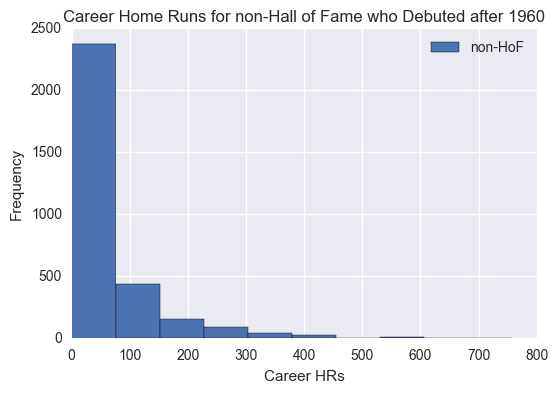

In [19]:
%matplotlib inline
plt.hist(ab_100_career_H_HR_RBI_non_HOF['HR'], label='non-HoF')
plt.xlabel("Career HRs")
plt.ylabel("Frequency")
plt.title("Career Home Runs for non-Hall of Fame who Debuted after 1960")
plt.legend(loc='upper right')

While there is still a high frequency in the first bucket on the x-axis, the graphs are not as skewed as before. For both non-HoF graphs there is a linear negative relationship visible. The HoF graphs are a little harder to see a patern, potentially due to the much smaller sample size. That said, in the HR histogram, if we ignore the biggest frequency on the far left, there is almost a normal distribution. I suspect if I were to limit season at bat minimums even further (say to 200 or 300) fully eliminate any possible pitchers included and expanded the years of includsion (maybe to debuting after WWII), there would be a nice, normal distribtion, with most HoF players having career home run totals close to the mean.

For the final part of the data exploration phase, I am going to more closely analyze the career batting averages for HoF and non-HoF players that I touched on early. First, I'm going to construct a box-plot to visualize the two groups, then I'm going to conduct an independt variable t-test to determine if I can reject or fail to reject my hypothesis from the question phase.

Populating the interactive namespace from numpy and matplotlib


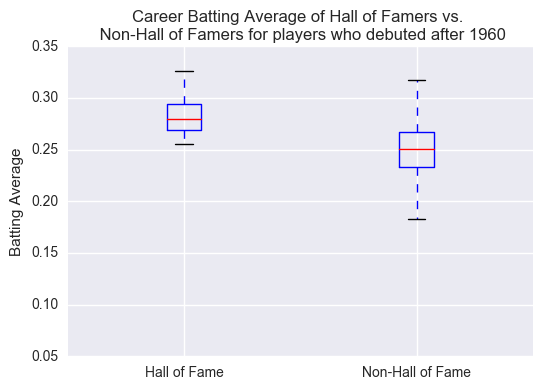

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%pylab inline

fig = plt.figure()
ax = fig.add_subplot(111)

x1 = clean_career_BA_HOF['BA']
x2 = clean_career_BA_non_HOF['BA'].values

labels1 = ['Hall of Fame','Non-Hall of Fame']

ax.boxplot([x1,x2], labels = labels1)

ax.set_ylabel('Batting Average')
ax.set_title('Career Batting Average of Hall of Famers vs. \n Non-Hall of Famers for players who debuted after 1960')
plt.legend()
plt.show()

In the boxplot we can see the difference in means for the two samples looks relatively small. That said, small increments/differences in batting average involve a rather significant increase in hits, due to the large number of at bats most players take during a career. We can clearly see there is a difference in the means of the two groups, but I really want to see if there is a *statisitcally significant* difference. To determine statistical significance I am going to conduct a independent two-sample T-Test and compre that t-statistic to the critical value for a two tailed 95% confidence level. 

But befoer I can do my T-Test, I need to determine if there is equal or unequal variance among the two samples. For that I am going to conduct an F-test. The f-statistic will be determined by dividing the larger sample variance (HoF) by the smaller sample variance (non-HoF). 

In [22]:
HoF_BA_var = numpy.var(clean_career_BA_HOF['BA'].values)
non_HoF_BA_var = numpy.var(clean_career_BA_non_HOF['BA'].values)
print 'HoF BA Variance'
print HoF_BA_var
print '\n' 
print 'non-HoF BA Variance'
print non_HoF_BA_var
print '\n'
f_stat = HoF_BA_var / non_HoF_BA_var
print 'F-Stat'
print f_stat

HoF BA Variance
0.00194511163414


non-HoF BA Variance
0.000750982588926


F-Stat
2.59008885535


Now that I have my F-Statistic, I need to determin my critical value. Using an [online F-cricial value calculator](http://www.danielsoper.com/statcalc/calculator.aspx?id=4) with 41 df for the numerator and 3147 df for the denominator and a .025 probability level (since I am using two-tailed hypothesis test at the 95% confidence level), I get a F-critical value of 1.482. Since my F-Stat (2.590) is above the critical value, I can conclude the variances of the two samples *are not* equal. And just to double check my work, I used my F-stat and degrees of freedom in [GraphPads quick calculator ](http://www.graphpad.com/quickcalcs/pValue1/) to get a P value of of less than 0.0001. Again, this confirms the two variances are not equal. This will allow me to conduct my T-test in the cell below.

In [23]:
import scipy.stats
from scipy.stats import ttest_ind, ttest_ind_from_stats

scipy.stats.ttest_ind(clean_career_BA_HOF['BA'].values, clean_career_BA_non_HOF['BA'].values, axis=0, equal_var=False)

Ttest_indResult(statistic=3.196797598207556, pvalue=0.0026611536597723985)

With a 3188 degrees of freedom (over 1000), the [t-critical value for a two-tailed t-test at 95% confidence](https://s3.amazonaws.com/udacity-hosted-downloads/t-table.jpg) is 1.960. Therefore, with a t-statistic of 3.197 we can reject the null hypothesis. I can re-confirm the rejection of the null hypothesis since the scipy stats T-Test also gives a p-value, which is .00267, well below the .025 needed for my hypothesis test.

### Data Analysis Proecess - Part 4 - Communication and conclusion

For the conclusion of this project I want to return to the hypothesis test from the beginning. <br/>
*Independent two-sample t-test*<br/>
*H_0: x = y*<br/>
*H_A: x != y*<br/>
*Where x = mean career batting average of players who debuted in MLB after January 1, 1960 who **ARE** in the Hall of fame*<br/>
*Where y = mean career batting average of players who debuted in MLB after January 1, 1960 who **ARE NOT** in the Hall of fame*<br/>
*Confidence interval = 95%<br/>

*Sample 1 (HOF players)*: mean:.271, df: 41, std: 0.044638
*Sample 1 (non-HOF players)*: mean:0.249, df: 3147, std: 0.0274

**Results of hypothesis test:**<br/>
*alpha*: .05<br/>
t-critical: 1.960<br/>
test: independent, two-sample t-test<br/>
t-statistic: 3.197<br/>
df: 3188<br/>
p-value: .00267<br/>

*APA Style Results*:<br/>
t(3188) = 3.197, p = .00267, two-tailed

As stated before, with these results we can reject the null hypothesis and conclude that the difference in career batting averages for Hall of Fame players is statistically significant from the career batting averages for non-Hall of Fame players. Of course we can't say much more than that, as getting into the baseball hall of fame consists of a lot more than just having a higher career batting average.

While this was a fun exercise, there is a lot more data cleaning and analysis that can be done. First and foremost, if I had more time, I would like to like to expand the years involved (moving the debut date to January 1, 1946) and figure out a way to full remove pitchers and other low outliers from the analysis. I would also be interesting in trying to look at all the offensive statistics (include advanced ones, like Wins Above Replacement (WAR)), get R^2 values and try to figure out what the signle biggest contributing factor is to players who are in the Hall of Fame. 

### Websites and resources used:
- I used the Udacity forum to ask two questions and further searched previous questions to get help with my box plot
- I used *countless*, Stack Overflow queries to help with data wragling and examinition issues